# Eye Roll detector: data generation

I'm not sharing the dataset itself, but the code that generates it

Import all necessary libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import face_recognition as fr

In [2]:
video_file = 'eye_roll_test_close.avi'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Capturing selfie video

Instructions:

1. Capture normal look for a 1/3 of the time you are plannig for this video set
2. Roll eyes for 1/3 of the time
3. Capture normal look for 1/6 of the time
4. Roll eyes for 1/6 of the time

By this you'll be able to separate the dataset into training and alidation sets with positive and negative examples

In [5]:
cap = cv2.VideoCapture(video_file)
count = 0
frames=[]
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
frames=[] 
# Read until video is completed
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()  
    frames.append(frame)    
    if ret == True:  
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
        # Break the loop
    else: 
        break
        
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [6]:
len(frames)

1262

## Function get_eyes:

uses landmarks detected by face_recognition to find the coordinates of the eyes and by this to get the images of eyes only, each eye (left and right) separately

In [17]:
def get_eyes(image, landmarks):
    if image is None or landmarks is None:
        return (None,None)
    eyes=image.copy() 
    x1,y1 = landmarks[0]['left_eye'][0][0], landmarks[0]['left_eye'][1][1]
    x2,y2 = landmarks[0]['left_eye'][3][0], landmarks[0]['left_eye'][5][1]        
    shape1 = [(x1-5,y1-5), (x2+5,y2+5)]
    
    x11,y11 = landmarks[0]['right_eye'][0][0], landmarks[0]['right_eye'][1][1]
    x21,y21 = landmarks[0]['right_eye'][3][0], landmarks[0]['right_eye'][5][1]    
    shape2 = [(x11-5,y11-5), (x21+5,y21+5)]
   
    left_eye = eyes[shape1[0][1]:shape1[1][1],shape1[0][0]:shape1[1][0],:]
    right_eye = eyes[shape2[0][1]:shape2[1][1],shape2[0][0]:shape2[1][0],:]
    
    return (left_eye,right_eye)

In [23]:
a1,a2 = get_eyes(frames[400])

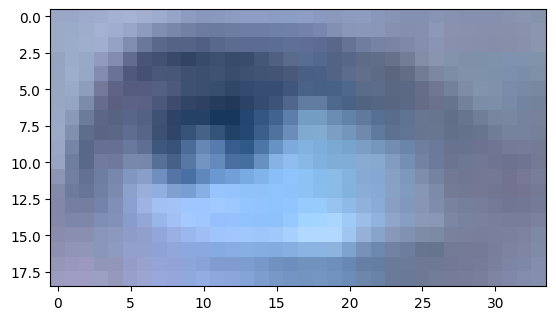

In [24]:
plt.imshow(a1)

## Build dataset

Go through frames
For each frame:
1. Localize eyes
2. Extract images of eyes only
3. Write down images into appropiate folder: right/left train/validation/test roll/no_roll

In [28]:
left_train_roll ="data/Elina_eyes/left/train/roll"
left_train_no_roll ="data/Elina_eyes/left/train/no_roll"
right_train_roll ="data/Elina_eyes/right/train/roll"
right_train_no_roll ="data/Elina_eyes/right/train/no_roll"

left_validation_roll ="data/Elina_eyes/left/validation/roll"
left_validation_no_roll ="data/Elina_eyes/left/validation/no_roll"
right_validation_roll ="data/Elina_eyes/right/validation/roll"
right_validation_no_roll ="data/Elina_eyes/right/validation/no_roll"

path = 'data/Elina_eyes'
for i in range(1251):
    landmarks_collection = fr.face_landmarks(resultImg)
    if len(landmarks_collection) !=1:
        continue
    left,right = get_eyes(frames[i],landmarks_collection[0])
    path_left =""
    path_right=""
    #traning - normal eyes gaze
    if i<=320:
        path_left =left_train_no_roll
        path_right =  right_train_no_roll
    #training - eye roll   
    if i>=335 and i<=775:     
        path_left =left_train_roll
        path_right =  right_train_roll
    #validation - normal eyes gaze    
    if i>=785 and i<=975:     
        path_left =left_validation_no_roll
        path_right =  right_validation_no_roll
    #validation - eye roll    
    if i>=975:     
        path_left =left_validation_roll
        path_right =  right_validation_roll    
    if(path_left!=""):       
        cv2.imwrite(path_left+"/left_"+str(i)+".png",left)
       
    if(path_right!=""):
        cv2.imwrite(path_right+"/right_"+str(i)+".png",right)
     

### Build test dataset from

In [29]:
left_test ="data/Elina_eyes/left/test"
right_test ="data/Elina_eyes/right/test"

In [31]:
for i in range(321,325):
    left,right = get_eyes(frames[i])
    cv2.imwrite(left_test+"/left_"+str(i)+".png",left)
    cv2.imwrite(right_test+"/right_"+str(i)+".png",right)
    
for i in range(776,785):
    left,right = get_eyes(frames[i])
    cv2.imwrite(left_test+"/left_"+str(i)+".png",left)
    cv2.imwrite(right_test+"/right_"+str(i)+".png",right)    
    

In [3]:
left_eye_model = 'data/Elina_eyes/left_eye.h5'
right_eye_model = 'data/Elina_eyes/right_eye.h5'
from tensorflow.keras.models import load_model

In [34]:
#imports
import cv2
from matplotlib import pyplot as plt
import numpy as np
import keras.utils as image

#create video captioning object
cap = cv2.VideoCapture(0)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('eye_roll_demo.avi', fourcc, 10.0, (640,  480))
#out = cv2.VideoWriter(name,fourcc, 20,(320,180),False)

frames = []
#ocr = PaddleOCR(lang='en')


#faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
flagD= False
txts =""
lmodel = load_model('data/Elina_eyes/left_eye.h5')
rmodel = load_model('data/Elina_eyes/right_eye.h5')

while True:    
    result, frame = cap.read()  
    l,r=get_eyes(frame)
    if(l is not None and r is not None):
        #l_img = image.load_img(l, target_size=(20, 30))
        l_img =  cv2.resize(l, (30,20), interpolation = cv2.INTER_AREA)        
        x = np.expand_dims(l_img, axis=0)
        images = np.vstack([x])       
        l_classes = lmodel.predict(images, batch_size=10)       
        
        
        #r_img =  cv2.resize(r, (30,20), interpolation = cv2.INTER_AREA)
        ##x = image.img_to_array(r_img)
        #x = np.expand_dims(r_img, axis=0)
        #images = np.vstack([x])        
        #r_classes = rmodel.predict(images, batch_size=10)        
        
       
        if l_classes[0]>=0.5: #and r_classes[0]>=0.5:
            txts+=" Rolled eyes"
        
        cv2.putText(frame, f'{txts}', (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0006*frame.shape[1],
                    (255,255,255), int(0.002*frame.shape[1]), cv2.LINE_AA)    
    frames.append(frame)   
    out.write(frame)
    cv2.imshow("frame", frame) # qqqqThis will open an independent window       
    if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed        
        break

# close the already opened camera
cap.release()    
out.release()
# Destroy all the windows        
cv2.destroyAllWindows() 

1/1 [==============================] - 0s 25ms/step


In [52]:
lmodel.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 16, 26, 24)        1824      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 8, 13, 24)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 8, 13, 24)         0         
                                                                 
 conv2d_68 (Conv2D)          (None, 6, 11, 24)         5208      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 3, 5, 24)         0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 3, 5, 24)        

In [31]:
# close the already opened camera
cap.release()    
out.release()
# Destroy all the windows        
cv2.destroyAllWindows() 

In [8]:
i=image.load_img('data/Elina_eyes/left/test/left_321.png', target_size=(20, 30))

In [71]:
i

In [9]:
ii=image.img_to_array(i)

In [13]:
iii=np.vstack([ii])

In [14]:
iii.shape

(20, 30, 3)